In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

Action Items:
* chunk times into categories
* compare 2020 to 2019 data
* ~~Find results based on Weekdays only~~

In [2]:
#turnstile = pd.read_csv('./src/NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

In [3]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + '.txt')
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list, ignore_index=True)
    df.columns = df.columns.str.strip() #Exits Column name has large trailing whitespace
    return df
#get August Data YYMMDD
#Currently mta contains data from September 19, 2020 to April 04, 2020

#2020 data
mta = read_mta(['200919', 
                '200912',
                '200905',
                '200801',
                '200808',
                '200815',
                '200822',
                '200829',
                '200725',
                '200718',
                '200711',
                '200704',
                '200627'])

mta19 = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

'''                '200725',
                '200718',
                '200711',
                '200704',
                '200627',
                '200620',
                '200613',
                '200606',
                '200530',
                '200523',
                '200516',
                '200509',
                '200502',
                '200425',
                '200418',
                '200411',
                '200404',
                ])'''

"                '200725',\n                '200718',\n                '200711',\n                '200704',\n                '200627',\n                '200620',\n                '200613',\n                '200606',\n                '200530',\n                '200523',\n                '200516',\n                '200509',\n                '200502',\n                '200425',\n                '200418',\n                '200411',\n                '200404',\n                ])"

In [4]:
mta

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009
...,...,...,...,...,...,...,...,...,...,...,...
2711627,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,05:00:00,REGULAR,5554,514
2711628,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,09:00:00,REGULAR,5554,514
2711629,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,13:00:00,REGULAR,5554,514
2711630,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,17:00:00,REGULAR,5554,514


In [5]:
mta.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,16:00:00,REGULAR,7457230,2535953
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,20:00:00,REGULAR,7457355,2535959
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,00:00:00,REGULAR,7457420,2535969
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,04:00:00,REGULAR,7457424,2535972
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,08:00:00,REGULAR,7457431,2535980


## Clean Data
* convert to datetime
* get change in turnstile data
* remove negative entries and exits
* remove total traffic greater than 2400
* convert datetime to day of week int


In [6]:
#convert to datetime
mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)

In [7]:
mta.DESC.value_counts()
#recovered audits are <1% of total data. Drop!

REGULAR       2699431
RECOVR AUD      12201
Name: DESC, dtype: int64

In [8]:
#only interested in regular audits. 
mta = pd.DataFrame(mta[mta.DESC == 'REGULAR'])

In [9]:
mta.sort_values(by=['datetime'], inplace=True)

In [10]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta['n_in'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_out'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [11]:
#adding n_in and n_out to get total turnstile traffic between audits
mta['turn_traffic'] = mta.n_in + mta.n_out

In [12]:
mta.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic
1689158,A081,R028,04-00-00,FULTON ST,ACJZ2345,BMT,07/21/2020,23:00:00,REGULAR,210186,1247755,2020-07-21 23:00:00,4.0,10.0,14.0
882344,N020,R101,00-00-01,145 ST,ABCD,IND,08/02/2020,16:00:00,REGULAR,3003497,2225295,2020-08-02 16:00:00,98.0,83.0,181.0
2558481,N063,R011,02-06-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/26/2020,08:00:00,REGULAR,4676920,1036850,2020-06-26 08:00:00,0.0,8.0,8.0
1991002,N550,R242,01-06-01,18 AV,F,IND,07/11/2020,08:00:00,REGULAR,336953,162601,2020-07-11 08:00:00,0.0,0.0,0.0
2058164,R323,R387,00-00-02,WEST FARMS SQ,25,IRT,07/15/2020,09:00:00,REGULAR,3525327,2701064,2020-07-15 09:00:00,88.0,72.0,160.0


In [13]:
mta.describe()
#n_in and n_out have negative quantities

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,2.699431e+06,2.699431e+06,2.694432e+06,2.694432e+06,2.694432e+06
mean,4.265449e+07,3.496796e+07,-2.380128e+02,4.761911e+02,2.381783e+02
std,2.175794e+08,1.982494e+08,3.602118e+06,2.759846e+06,5.556849e+06
min,0.000000e+00,0.000000e+00,-1.895328e+09,-1.813836e+09,-3.051188e+09
25%,2.799710e+05,1.203770e+05,1.000000e+00,2.000000e+00,4.000000e+00
50%,1.785383e+06,1.039748e+06,1.300000e+01,1.500000e+01,3.700000e+01
75%,6.449905e+06,4.305638e+06,5.000000e+01,4.900000e+01,1.090000e+02
max,2.128760e+09,2.123274e+09,1.879048e+09,1.740393e+09,2.371192e+09


In [14]:
#drop negative traffic and assume maximum turns within 4 hours to be 2400 '1 person every 6 seconds'
#assumed all timeslots are 4 hours -- look at diff on datetime
#negative data may be when turnstiles are reset but represent a small sample of population
###Maybe mask for turn_traffic < 2400
mask = (mta.n_in >= 0) & (mta.n_out >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 2400)
mta = mta[mask]

In [15]:
mta.describe()

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,2.665954e+06,2.665954e+06,2.665954e+06,2.665954e+06,2.665954e+06
mean,3.133542e+07,2.292442e+07,3.829337e+01,3.995416e+01,7.824753e+01
std,1.754565e+08,1.470848e+08,6.100340e+01,6.831332e+01,1.079701e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.734612e+05,1.177110e+05,1.000000e+00,2.000000e+00,5.000000e+00
50%,1.733542e+06,1.010376e+06,1.400000e+01,1.500000e+01,3.800000e+01
75%,6.251144e+06,4.114498e+06,5.000000e+01,4.900000e+01,1.100000e+02
max,2.128759e+09,2.123270e+09,2.210000e+03,2.242000e+03,2.344000e+03


In [16]:
#n_in and n_out minimum and maximum values are still unreasonable 
#mta.describe()

In [17]:
#try .dt.dayofweek()
mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())


## Analysis
### Ranking Stations on traffic of All Time

In [18]:
mta['total_st_traffic'] = mta.groupby('STATION').turn_traffic.transform('sum')

In [19]:
stations_totals = mta[['STATION', 'total_st_traffic']]

In [20]:
stations_totals = stations_totals.drop_duplicates()

In [21]:
stations_totals.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [22]:
stations_totals[:11]

,STATION,total_st_traffic
2561076,34 ST-PENN STA,4731445.0
2603254,34 ST-HERALD SQ,3770944.0
2651082,125 ST,3723671.0
2529225,86 ST,3378209.0
2509960,14 ST-UNION SQ,3233501.0
2664502,GRD CNTRL-42 ST,3065539.0
2557646,42 ST-PORT AUTH,3017721.0
2604833,23 ST,2810212.0
2698132,FLUSHING-MAIN,2728575.0
2600693,FULTON ST,2635630.0


Text(0.5, 0, 'Total Traffic')

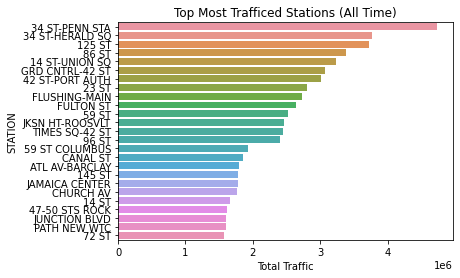

In [23]:
sns.barplot(x='total_st_traffic', y='STATION', data=stations_totals[:25])
plt.title('Top Most Trafficed Stations (All Time)')
plt.xlabel('Total Traffic')

**Filter for Top N Stations (N=25)**

In [24]:
#Assume focus on top ten total traffic

#increase to top 25
s = [each for _, each in stations_totals[:25]['STATION'].items()]

In [25]:
#Change df name to top_ranking
top_ranked_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [26]:
top_ranked_df.STATION.value_counts()

34 ST-PENN STA     53056
FULTON ST          52126
GRD CNTRL-42 ST    39685
23 ST              39024
86 ST              34359
CANAL ST           31150
34 ST-HERALD SQ    28207
ATL AV-BARCLAY     27265
14 ST              26641
42 ST-PORT AUTH    25803
59 ST              25701
PATH NEW WTC       23343
TIMES SQ-42 ST     22953
125 ST             22704
14 ST-UNION SQ     22436
59 ST COLUMBUS     22321
96 ST              19957
47-50 STS ROCK     19638
CHURCH AV          19613
JKSN HT-ROOSVLT    15600
72 ST              15341
FLUSHING-MAIN      14113
JAMAICA CENTER     11662
145 ST             10872
JUNCTION BLVD       6519
Name: STATION, dtype: int64

In [27]:
top_ranked_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,total_st_traffic
2698132,R534,R055,01-03-00,FLUSHING-MAIN,7,IRT,06/20/2020,04:00:00,REGULAR,8811043,8522154,2020-06-20 04:00:00,1.0,2.0,3.0,5,2728575.0
2557646,N062,R011,01-05-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,100668500,0,2020-06-20 04:00:00,0.0,0.0,0.0,5,3017721.0
2551641,N020,R101,00-00-02,145 ST,ABCD,IND,06/20/2020,04:00:00,REGULAR,11807661,12290425,2020-06-20 04:00:00,6.0,19.0,25.0,5,1781370.0
2558696,N063A,R011,00-00-03,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,5014877,2274472,2020-06-20 04:00:00,4.0,7.0,11.0,5,3017721.0
2604833,N508,R453,00-00-00,23 ST,FM,IND,06/20/2020,04:00:00,REGULAR,238620663,459121876,2020-06-20 04:00:00,1.0,6.0,7.0,5,2810212.0


In [28]:
#try top_ranked_df.dt.dayofweek()
#top_ranked_df['day_of_week'] = top_ranked_df['datetime'].apply(lambda x : x.weekday())

**Determine Daily Cumulative traffic by day of week from Top Ten Stations of all time**

In [29]:
#or take the mean? ### Rename to cumulative?
top_ranked_df['daily_traffic'] = top_ranked_df.groupby(['STATION', 'day_of_week']).turn_traffic.transform('sum')
#Gives cumulative traffic by day of week

In [30]:
daily_df = pd.DataFrame(top_ranked_df[['STATION', 'day_of_week', 'daily_traffic']])

In [31]:
daily_df.drop_duplicates(inplace=True)

Text(0.5, 1.0, 'Daily Traffic')

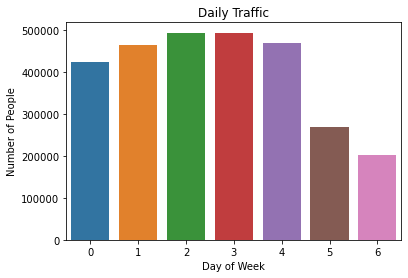

In [32]:
sns.barplot(x='day_of_week', y='daily_traffic', data=daily_df[daily_df.STATION=='23 ST'])

plt.xlabel('Day of Week')
plt.ylabel('Number of People')
plt.title('Daily Traffic')

In [33]:
top_ranked_df['traffic_by_time_by_station'] = top_ranked_df.groupby(['STATION', 'day_of_week', 'TIME']).turn_traffic.transform('sum')

In [34]:
top_ranked_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,total_st_traffic,daily_traffic,traffic_by_time_by_station
2698132,R534,R055,01-03-00,FLUSHING-MAIN,7,IRT,06/20/2020,04:00:00,REGULAR,8811043,8522154,2020-06-20 04:00:00,1.0,2.0,3.0,5,2728575.0,306578.0,5280.0
2557646,N062,R011,01-05-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,100668500,0,2020-06-20 04:00:00,0.0,0.0,0.0,5,3017721.0,316092.0,2210.0
2551641,N020,R101,00-00-02,145 ST,ABCD,IND,06/20/2020,04:00:00,REGULAR,11807661,12290425,2020-06-20 04:00:00,6.0,19.0,25.0,5,1781370.0,219838.0,7293.0
2558696,N063A,R011,00-00-03,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,5014877,2274472,2020-06-20 04:00:00,4.0,7.0,11.0,5,3017721.0,316092.0,2210.0
2604833,N508,R453,00-00-00,23 ST,FM,IND,06/20/2020,04:00:00,REGULAR,238620663,459121876,2020-06-20 04:00:00,1.0,6.0,7.0,5,2810212.0,269026.0,2868.0


In [35]:
top_ranked_df['d_traffic'] = top_ranked_df.groupby(['STATION', 'DATE']).turn_traffic.transform('sum')

In [36]:
top_ranked_df['mean_d_traffic'] = top_ranked_df.groupby(['STATION','day_of_week']).d_traffic.transform('mean')

### Ranking Stations filtered for Weekdays

In [38]:
wkday_df = pd.DataFrame(mta[mta.day_of_week < 5])

In [39]:
wkday_df['total_st_traffic'] = wkday_df.groupby('STATION').turn_traffic.transform('sum')

In [40]:
wkday_rank = pd.DataFrame(wkday_df[['STATION', 'total_st_traffic']])

In [41]:
wkday_rank.drop_duplicates(inplace=True)

In [42]:
wkday_rank.sort_values('total_st_traffic', ascending=False, inplace=True)

In [43]:
wkday_rank.head(25)

,STATION,total_st_traffic
2643379,34 ST-PENN STA,3870985.0
2508249,34 ST-HERALD SQ,3086514.0
2552786,125 ST,2936132.0
2529194,86 ST,2780528.0
2664849,GRD CNTRL-42 ST,2614805.0
2510551,14 ST-UNION SQ,2582463.0
2558833,42 ST-PORT AUTH,2452743.0
2561843,23 ST,2339046.0
2600788,FULTON ST,2202432.0
2698185,FLUSHING-MAIN,2185677.0


**filter for top N stations (N=25)**

In [44]:
s = [each for _, each in wkday_rank[:25]['STATION'].items()]

wkday_rank[wkday_rank.STATION.isin(s)]

,STATION,total_st_traffic
2643379,34 ST-PENN STA,3870985.0
2508249,34 ST-HERALD SQ,3086514.0
2552786,125 ST,2936132.0
2529194,86 ST,2780528.0
2664849,GRD CNTRL-42 ST,2614805.0
2510551,14 ST-UNION SQ,2582463.0
2558833,42 ST-PORT AUTH,2452743.0
2561843,23 ST,2339046.0
2600788,FULTON ST,2202432.0
2698185,FLUSHING-MAIN,2185677.0


### Top Stations Average Traffic by Day 

In [45]:
df = pd.DataFrame(top_ranked_df[['STATION', 'day_of_week', 'mean_d_traffic']])

In [46]:
df.drop_duplicates(inplace=True)

In [47]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
df.day_of_week = df.day_of_week.map(lambda x : str(x)).map(wkday_dict)

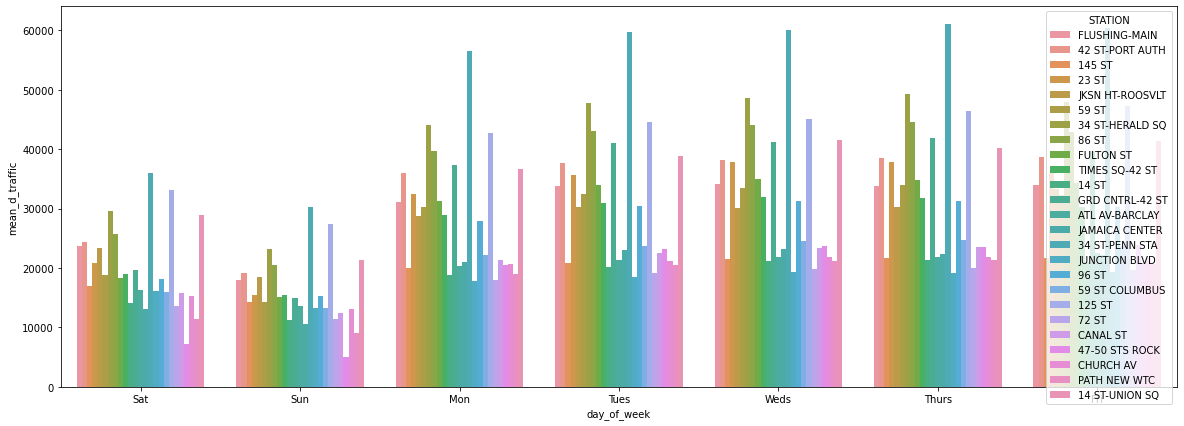

In [48]:
plt.figure(figsize=[20,7])
sns.barplot(x='day_of_week', y='mean_d_traffic', hue='STATION', data=df)

In [49]:
pivot_df = df.pivot(index='day_of_week', columns='STATION', values='mean_d_traffic')
pivot_df

STATION,125 ST,14 ST,14 ST-UNION SQ,145 ST,23 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-PORT AUTH,47-50 STS ROCK,59 ST,...,CANAL ST,CHURCH AV,FLUSHING-MAIN,FULTON ST,GRD CNTRL-42 ST,JAMAICA CENTER,JKSN HT-ROOSVLT,JUNCTION BLVD,PATH NEW WTC,TIMES SQ-42 ST
day_of_week,,,,,,,,,,,,,,,,,,,,,
Fri,47322.862248,21070.620841,41381.692732,21749.769231,36068.218970,48015.087871,60420.934168,38715.077781,20880.287852,32294.407909,...,23813.703237,21689.855670,33949.620868,34302.633115,39681.194320,22272.299754,33224.205722,19256.615385,20751.664277,30335.269091
Mon,42732.768971,18840.495332,36591.336882,19964.547315,32535.023903,44108.870904,56526.215720,35935.911288,20583.384670,30228.820859,...,21363.792956,20740.300458,31084.802432,31364.763464,37379.505298,20954.357417,28687.044268,17885.140107,19002.641252,28914.356599
Sat,33194.930276,14051.176833,28887.874527,16995.998695,20790.101966,29682.406682,36028.029424,24349.237781,7185.321739,18869.648291,...,15857.382340,15370.601014,23699.002775,18354.363624,19663.113184,13123.488016,23390.818468,16123.644252,11446.965517,19053.436896
Sun,27485.078834,11266.505683,21360.692308,14319.958683,15537.334585,23221.909294,30292.283675,19163.934122,5009.338375,14315.423491,...,12429.638199,13046.597173,18012.055937,15185.729492,15000.491441,10647.344401,18457.907810,13235.761697,8997.063549,15417.846154
Thurs,46461.786638,21361.702590,40181.625709,21689.859729,37904.749731,49252.568520,60983.310340,38510.324242,23563.952245,33988.983301,...,23483.640181,21920.288510,33790.543456,34804.484771,41901.475556,22381.303993,30295.980930,19197.983957,21414.028035,31762.649925
Tues,44513.685556,20219.113193,38838.456372,20871.230769,35637.782477,47698.899383,59782.167124,37754.085676,23254.909871,32490.243583,...,22553.153604,21237.912950,33799.349544,34016.814517,41079.563403,23108.833657,30336.395185,18534.846154,20591.794580,31002.883037
Weds,45084.554964,21104.149709,41617.783144,21534.989096,37789.688328,48669.661139,60136.802985,38239.910027,23758.461538,33399.193813,...,23309.540704,21899.426790,34165.762663,35039.014312,41263.607500,23125.721438,30055.581560,19391.846154,21249.241148,32038.230769


Text(0.5, 1.0, 'Daily Traffic of Top Ten Busiest Stations')

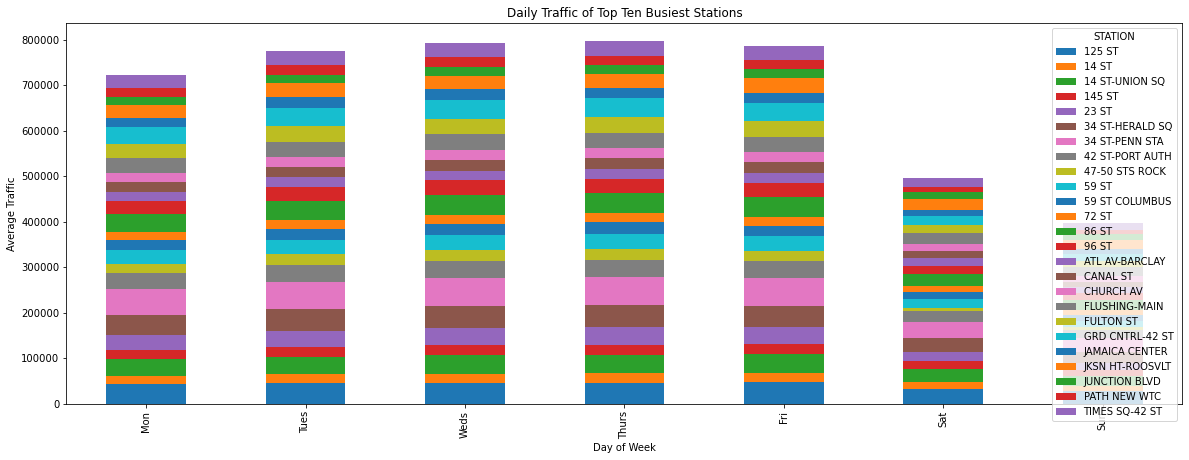

In [50]:
pivot_df.loc[['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],:].plot.bar(stacked=True, figsize=(20,7))

plt.xlabel('Day of Week')
plt.ylabel('Average Traffic')
plt.title('Daily Traffic of Top Ten Busiest Stations')

### Chunking timeslots into windows

break time into categories
00:00:00 < dt.datetime() < 04:00:00 
EX:
* Early Morning  0-7
* Morning Rush Hour 7-11
* Midafternoon 11-16
* Evening Rush Hour 16-21
* Late Evening 21-24


In [51]:
mta.TIME.value_counts().head(35)

04:00:00    225080
20:00:00    224688
16:00:00    224594
12:00:00    224456
08:00:00    224393
00:00:00    221690
05:00:00    166921
17:00:00    166534
21:00:00    166411
09:00:00    166363
13:00:00    166349
01:00:00    164688
22:00:00     10009
06:00:00      9963
14:00:00      9951
18:00:00      9945
10:00:00      9927
02:00:00      9841
11:00:00      3548
19:00:00      3547
15:00:00      3546
07:00:00      3544
23:00:00      3542
03:00:00      3503
08:22:00      3191
04:22:00      3156
16:22:00      3151
20:22:00      3120
12:22:00      3117
00:22:00      3103
10:30:00      1821
18:30:00      1820
22:30:00      1811
06:30:00      1802
14:30:00      1800
Name: TIME, dtype: int64